## 이 노드의 루브릭            

1. 의료 영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.         
- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  

2. 데이터 준비, 모델 구성 등의 과정이 다양한 실험이 체계적으로 수행되었다.   
- regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.          
- Accuracy 기준 85%에 도달하였다.       


## 목차           

1. 실험환경 Set-up          
- 사용할 사진 데이터를 가져오고, 길이를 세팅   
- 정상 사진과 타겟 사진의 밸런스 세팅
- Batch size, Epoch 등의 설정 변경
- 데이터 형식 세팅(라벨링, 이미지 크기 리사이징)

2. 데이터 준비하기          
- 원본 데이터의 전처리 및 배치 구성      
- augmentation 기법 적용 

3. 데이터 시각화        
- 원본 데이터의 확인
- augmentation 처리한 데이터의 확인

4. CNN 모델링     
- 모델 셋업 변경 1 - Convolution filter, 채널 개수, activation 등의 구조 변경
- 모델 셋업 변경 2 - Batch Normalization+Dropout 구성 변경   

5. 데이터 imbalance 처리   
- 데이터의 imbalance에 대응 가능한 class weight 적용을 뺀다면

6. 모델 훈련        
- optimizer나 learning rate 등의 변화

7. 결과 확인과 시각화      
- 훈련 과정의 history 그래프를 시각화하여 살펴보기  

8. 결론

## 1. 실험 환경 셋업          

In [1]:
#필요한 라이브러리 임포트 
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

print('필요한 라이브러리 임포트 완료')

필요한 라이브러리 임포트 완료


#### 1-1. 사용할 사진 데이터를 가져오고, 데이터 길이를 세팅

In [2]:
#데이터 로드
file_path = os.path.join(os.getenv('HOME'), 'SUBMIT_MISSION_GIT/ex14_Cancer/Picture/chest_xray')

print('파일 위치 확인 :', file_path)

파일 위치 확인 : /home/ssac23/SUBMIT_MISSION_GIT/ex14_Cancer/Picture/chest_xray


In [3]:
#데이터 가져오기
train_path = tf.io.gfile.glob(str(file_path+'/train/*/*'))
test_path = tf.io.gfile.glob(str(file_path+'/test/*/*'))
val_path = tf.io.gfile.glob(str(file_path+'/val/*/*'))

#파일을 올바르게 로드했는지 확인하기 위해 길이를 출력해본다.
print('훈련 데이터셋 길이 :', len(train_path))
print('테스트 데이터셋 길이 :', len(test_path))
print('검증 데이터셋 길이 :', len(val_path))

훈련 데이터셋 길이 : 5216
테스트 데이터셋 길이 : 624
검증 데이터셋 길이 : 16


> - 이 때, 훈련 데이터셋과 검증 데이터셋의 길이가 너무 치우쳐져 있으므로         
> - 이 데이터셋의 길이를 어느 정도 맞춰주기 위해 train_test_split을 활용한다.

In [4]:
#훈련 데이터셋과 합친 뒤, 비율을 정하여 나눠준다.
extend_path = tf.io.gfile.glob(str(file_path)+'/train/*/*')

#extend는 append와 달리, 기준 데이터와 같은 형식으로 붙여줌(확장)
extend_path.extend(tf.io.gfile.glob(str(file_path)+'/val/*/*'))
                   
#중간점검
print('분리하기 전, 전체 파일 길이 :' , len(extend_path))
                   
train_files, val_files = train_test_split(extend_path, test_size=0.2)
                   
#분리 결과
print('훈련 데이터셋 길이 :', len(train_files))
print('검증 데이터셋 길이 :', len(val_files))

분리하기 전, 전체 파일 길이 : 5232
훈련 데이터셋 길이 : 4185
검증 데이터셋 길이 : 1047


> - 훈련 데이터와 검증 데이터가 8:2 비율이 되도록 나누었다.

#### 1-2. 정상 사진(Normal)과 타겟 사진(Pneumonia) 의 밸런스 세팅

In [5]:
#훈련 데이터셋 안의 폐렴 이미지에서 정상:타겟의 비율 확인

count_normal = len([filename for filename in train_files if "NORMAL" in filename])
print('훈련 데이터셋 중 normal 사진 수 : ', str(count_normal))

count_pneumonia = len([filename for filename in train_files if "PNEUMONIA" in filename])
print('훈련 데이터셋 중 pneumonia 사진 수 : ', str(count_pneumonia))

print('정상:폐렴 사진 비율 = {:.2f} : {:.2f}'.format(float(str(count_normal/count_pneumonia)), float(str(count_pneumonia/count_pneumonia))))

훈련 데이터셋 중 normal 사진 수 :  1082
훈련 데이터셋 중 pneumonia 사진 수 :  3103
정상:폐렴 사진 비율 = 0.35 : 1.00


> - 정상:폐렴 사진 비율이 0.36:1 로 데이터셋이 치우쳐져 있는 것을 확인할 수 있다. 
> - 이는 학습에 악영향을 미칠 수 있으므로, 추후 조정이 필요하다.

#### 1-3. Batch Size 및 Epoch 변경 

In [6]:
#노드 실습에서 Batch Size=16, Image Size=[180,180], Epoch=25였음
#이미지 사이즈는 그대로 유지
IMAGE_SIZE = [180,180]

BATCH_SIZE = 32
EPOCHS = 100

> - 에포크 수를 4배로 늘리되, 배치 사이즈를 2배로 늘려  
> - 한번에 학습하는 양의 밸런스를 맞춰주었다.

## 2. 데이터 준비하기  

### 2-1. 원본 데이터의 전처리 및 배치 구성

In [7]:
#데이터를 가져옴
print('tensor_slices를 적용하기 전의 데이터 형식 : ', type(train_files))

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)

print('tensor_slices를 적용한 후의 데이터 형식 :' , type(train_dataset))

tensor_slices를 적용하기 전의 데이터 형식 :  <class 'list'>
tensor_slices를 적용한 후의 데이터 형식 : <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


> - 기존에는 list 형식이었던 데이터를, CNN에 넣기 위해 tensor 형식으로 변환해줘야 한다. 

In [8]:
#validation data도 같은 형식으로 변경하고, 길이가 위와 같은지 확인해준다.
validation_dataset = tf.data.Dataset.from_tensor_slices(val_files)
validation_tensor_count = tf.data.experimental.cardinality(validation_dataset).numpy()

#tf.data.experimental.cardinality 는 Returns the cardinality of dataset의 역할을 수행한다.
train_tensor_count = tf.data.experimental.cardinality(train_dataset).numpy()

print('train_dataset의 최종 수 : ', train_tensor_count)
print('validation_dataset의 최종 수 :', validation_tensor_count)

train_dataset의 최종 수 :  4185
validation_dataset의 최종 수 : 1047


> - 위에서 list 형태로 저장했던 train_files, validation_files 의 길이와     
> - tensor 형태로 저장한 train_dataset, validation_dataset의 길이가 같다는 것을 확인할 수 있다.

__1) 데이터 세팅을 위한 라벨링__ 

In [18]:
#라벨 이름을 확인
#클래스 네임을 가져와 [2:-1]을 하는 것 : 생으로 불러오면  ["b'NORMAL'" "b'PNEUMONIA'"] 이렇게 되기 때문.. 적당히 정제해주기 위해 [2:-1]을 적용해 줌
class_name = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]for item in tf.io.gfile.glob(str(file_path)+'/train/*')])

print('클래스 네임 :', class_name)

클래스 네임 : ['NORMAL' 'PNEUMONIA']


In [19]:
#라벨링해주는 함수
#os.path.sep은 파일 각 경로를 나눠 리스트로 리턴하는 함수 << 얘가 중요
def pneumonia_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

__2) 데이터 세팅을 위한 리사이징__

In [20]:
#이미지를 리사이징하는 함수
#tf.image.decode_jpeg => Decode a JPEG-encoded image to a uint8 tensor.
def image_resizing(img):
    img = tf.image.decode_jpeg(img, channels=3)
    
    #float타입으로 변환
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    #이미지 사이즈를 수정하고, 이를 반환한다.
    return tf.image.resize(img, IMAGE_SIZE)

__3) 이미지 라벨링(폐렴 사진에 한해)과 리사이징을 동시 수행하는 함수 세팅__

In [22]:
def preprocessing(file_path):
    #라벨링 처리
    label = pneumonia_label(file_path)
    
    #이미지 형식 변환 및 라벨링 처리
    img = tf.io.read_file(file_path)
    img = image_resizing(img)
    
    return img, label

__4) 데이터셋 최종 리사이징 및 세팅__ 

In [23]:
#데이터를 로드할 때, 하드웨어 상황에 맞춰 동적으로 로드할 수 있도록 한가지 세팅을 해주고 가자.
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
train_ds = train_dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)
validation_ds = validation_dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)

In [25]:
#변환을 마친 후, 몇 개의 샘플을 골라 이미지 형태와 라벨을 확인한다.
for image, label in train_ds.take(3):
    print('이미지 형태 : ', image.numpy().shape)
    print('라벨 이름 : ', label.numpy())

이미지 형태 :  (180, 180, 3)
라벨 이름 :  True
이미지 형태 :  (180, 180, 3)
라벨 이름 :  True
이미지 형태 :  (180, 180, 3)
라벨 이름 :  False


In [26]:
#테스트 데이터셋도 동일하게 처리해준다.
test_dataset = tf.data.Dataset.list_files(str(file_path+'/test/*/*'))

test_list_count = tf.data.experimental.cardinality(test_dataset).numpy()

test_ds = test_dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('테스트 데이터셋 길이 확인 :' , test_list_count)

테스트 데이터셋 길이 확인 : 624


__5) data 파이프라인으로 학습 전 세팅__

In [27]:
#배치 사이즈에 맞추어 셔플
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [28]:
#나중에 이 tensorflow에 대한 심화학습이 필요하겠군요...
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


In [20]:
train_ds = prepare_for_training(train_ds)
validation_ds = prepare_for_training(validation_ds)

print('훈련 데이터 최종 검증 : ', train_ds)
print('검증 데이터 최종 검증 : ', validation_ds)

훈련 데이터 최종 검증 :  <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
검증 데이터 최종 검증 :  <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


> - 데이터 형식을 맞춰주었고, 시각화를 통해 이를 확인해본다.

__6) 데이터의 시각화__           

- 데이터를 확인하기 위해, 첫 번째 배치 데이터셋을 추출      
- 이미지 배치와 라벨 배치를 따로 꺼내, 시각화 시에 각각 그림, 라벨로 보여줌

In [21]:
#next(이터레이터) : 는 '이터레이터' 안에서 값을 차례대로 꺼냄
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    #이번에는 배치 사이즈를 노드 실습의 2배로 늘렸었음
    #오류나니까 30개까지만 출력해보자
    for n in range(30):
        
        #plt.subplot(가로, 세로, 인덱스)
        ax = plt.subplot(5,6,n+1)
        plt.imshow(image_batch[n])
        
        #라벨이 있으면 폐렴사진이고,
        #없으면 정상 사진임
        if label_batch[n]:
            plt.title("PNEUMONIA")
            
        else:
            plt.title("NORMAL")
            
        plt.axis("off")

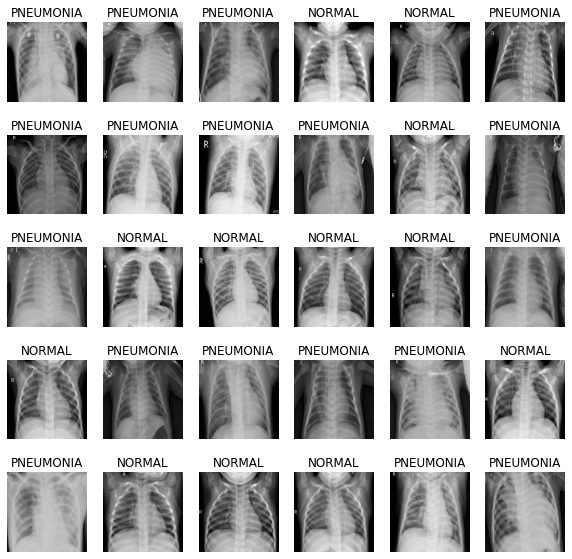

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

### 2-2. Augmented 기법 적용           

- 데이터의 절대적인 개수가 적기 때문에, 학습을 돕기 위해 augmentation을 적용하여 학습용 데이터셋을 늘려준다.  
- 단, augmentation에는 좌우 반전, 이미지 자르기(크롭), 밝기 조절 등 다양한 방법이 있으나   
- 의료용 데이터셋인 경우 노이즈 처리나 이미지 자르기가 오히려 학습에 방해가 될 수 있으므로,   
- __좌우 반전 augmentation만 적용해보도록 한다.__     

In [29]:
#augmented 처리하는 부분을 prepare_for_training 함수에 추가한다.
def augmented(image, label):    
    #랜덤하게 좌우 반전 처리
    image = tf.image.random_flip_left_right(image)
    
    return image, label

In [30]:
#좌우 반전 처리를 포함하여 함수 수정하기
def prepare_for_training(ds, shuffle_buffer_size=1000):
    #augmented 함수 적용
    ds = ds.map(augmented, num_parallel_calls=2)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [31]:
train_ds = prepare_for_training(train_ds)
validation_ds = prepare_for_training(validation_ds)

In [32]:
print(train_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


## 3. 데이터 시각화     

### 1. 원본 데이터 시각화

- 순서를 헷갈리는 바람에.. 원본 시각화를 순서에 맞지 않게 먼저 적용했었다.    
- 사진으로 남기는 결과...  

![원본데이터 시각화](./PostingPic/원본시각화.png)

### 2. Augmentation 후, 좌우반전된 데이터 시각화

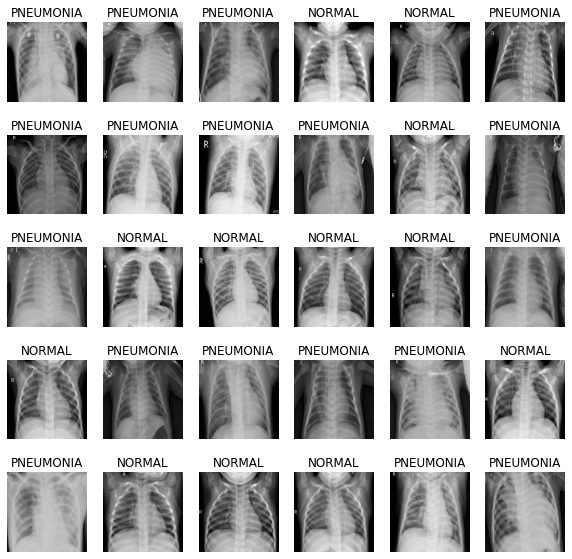

In [30]:
show_batch(image_batch.numpy(), label_batch.numpy())

> - 잘 확인하면, (1,3), (3,3)의 사진에 L 표시가 왼쪽에 표시되어 사진이 반전된 것을 알 수 있다. (원래 R이 왼쪽에 와 있음)

## 4. CNN 모델링       

- 기존의 모델링 방식과 다르게, 이번 노드에서는 하나의 CNN 구성을 '블록화' 하여 수행하도록 세팅하였다.     
- 일단, 기본적으로 Convolution Filter 및 채널 개수는 그대로 두되, activation만 adam으로 변경하여 적용해본다.

### 1. CNN 모델링       

- __일차적으로, 첫 시도에서는 Batch normalization만 수행하도록 하게 하자.__    

In [33]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### 2. 모델 설계하기

In [34]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        #마지막, 라벨을 분류해내는 Dense층만 추가
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 Imbalance 처리      

- 어느 정도 보완 처리를 해주었더라도, 데이터셋의 전체 수가 적고 imbalance하므로     
- Weight balancing(loss를 계산할 때, 특정 클래스의 데이터가 더 큰 loss값을 갖도록 가중치를 부여하는 법)  
- 처리를 하여 균형을 맞춰주도록 한다.

In [35]:
#weight_normal = 노말데이터가 갖는 가중치
#weight_pneumonia = 폐렴데이터가 갖는 가중치

weight_normal = (1/count_normal) * (train_tensor_count)/2.0
weight_pneumonia = (1/count_pneumonia) * (train_tensor_count)/2.0

class_weight = {0:weight_normal, 1:weight_pneumonia}

print('노말이 갖는 가중치 :{:.2f}'.format(weight_normal))
print('폐렴데이터가 갖는 가중치:{:.2f}'.format(weight_pneumonia))

노말이 갖는 가중치 :1.93
폐렴데이터가 갖는 가중치:0.67


## 6. 모델 훈련             

- 모델 훈련에는 GPU 사용     
- 최종적으로 분류할 이미지 클래스는 2개이므로, 이진 교차 엔트로피 사용 

In [36]:
with tf.device('/GPU:0'):
    model= build_model()
    
    METRICS=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
#모델 훈련
#class weight 제외하고 먼저 훈련
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=train_tensor_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_ds,
        validation_steps=train_tensor_count // BATCH_SIZE,
        #class_weight= tf.convert_to_tensor(class_weight, dtype=tf.float32)
    )

Epoch 1/100
130/130 [==============================] - 44s 335ms/step - loss: 0.2996 - accuracy: 0.8697 - precision: 0.8880 - recall: 0.9433 - val_loss: 0.5907 - val_accuracy: 0.7450 - val_precision: 0.7450 - val_recall: 1.0000
Epoch 2/100
130/130 [==============================] - 39s 299ms/step - loss: 0.1214 - accuracy: 0.9543 - precision: 0.9686 - recall: 0.9698 - val_loss: 0.5998 - val_accuracy: 0.7447 - val_precision: 0.7447 - val_recall: 1.0000
Epoch 3/100
130/130 [==============================] - 38s 294ms/step - loss: 0.1058 - accuracy: 0.9584 - precision: 0.9733 - recall: 0.9705 - val_loss: 0.5543 - val_accuracy: 0.7440 - val_precision: 0.7440 - val_recall: 1.0000
Epoch 4/100
130/130 [==============================] - 39s 303ms/step - loss: 0.0951 - accuracy: 0.9630 - precision: 0.9726 - recall: 0.9776 - val_loss: 0.4801 - val_accuracy: 0.7450 - val_precision: 0.7450 - val_recall: 1.0000
Epoch 5/100
130/130 [==============================] - 39s 297ms/step - loss: 0.0764 - a

Epoch 37/100
130/130 [==============================] - 38s 293ms/step - loss: 0.0114 - accuracy: 0.9954 - precision: 0.9971 - recall: 0.9968 - val_loss: 0.1064 - val_accuracy: 0.9793 - val_precision: 0.9855 - val_recall: 0.9868
Epoch 38/100
130/130 [==============================] - 38s 292ms/step - loss: 0.0206 - accuracy: 0.9942 - precision: 0.9965 - recall: 0.9958 - val_loss: 0.1799 - val_accuracy: 0.9685 - val_precision: 0.9652 - val_recall: 0.9935
Epoch 39/100
130/130 [==============================] - 38s 294ms/step - loss: 0.0250 - accuracy: 0.9933 - precision: 0.9954 - recall: 0.9954 - val_loss: 0.1198 - val_accuracy: 0.9745 - val_precision: 0.9817 - val_recall: 0.9842
Epoch 40/100
130/130 [==============================] - 38s 296ms/step - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9977 - recall: 0.9964 - val_loss: 0.1484 - val_accuracy: 0.9635 - val_precision: 0.9943 - val_recall: 0.9565
Epoch 41/100
130/130 [==============================] - 38s 294ms/step - loss: 0.006

130/130 [==============================] - 38s 292ms/step - loss: 0.0145 - accuracy: 0.9962 - precision: 0.9974 - recall: 0.9974 - val_loss: 0.1425 - val_accuracy: 0.9731 - val_precision: 0.9734 - val_recall: 0.9910
Epoch 73/100
130/130 [==============================] - 38s 292ms/step - loss: 0.0028 - accuracy: 0.9988 - precision: 0.9990 - recall: 0.9994 - val_loss: 0.2768 - val_accuracy: 0.9659 - val_precision: 0.9613 - val_recall: 0.9942
Epoch 74/100
130/130 [==============================] - 38s 294ms/step - loss: 0.0017 - accuracy: 0.9995 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.1536 - val_accuracy: 0.9728 - val_precision: 0.9866 - val_recall: 0.9768
Epoch 75/100
130/130 [==============================] - 38s 295ms/step - loss: 0.0019 - accuracy: 0.9995 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.1356 - val_accuracy: 0.9805 - val_precision: 0.9806 - val_recall: 0.9935
Epoch 76/100
130/130 [==============================] - 38s 290ms/step - loss: 0.0051 - accuracy:

## 7. 결과 확인과 시각화

### 1. 결과 확인          

- 100 epoch로 학습시킨 후, 다음과 같은 결과를 얻었다.

![100](./PostingPic/100에포크.png)

> - 이 결과를 시각화하여 살펴보자.

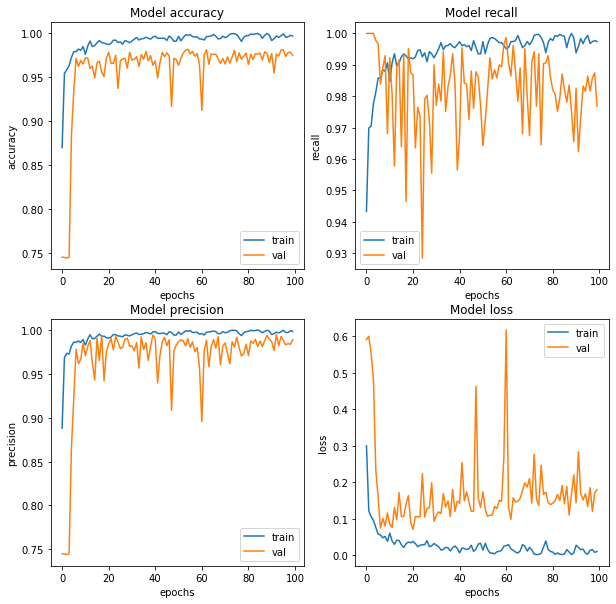

In [39]:
#훈련하며 쌓인 히스토리를 그래프로 만들어 확인
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'precision', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

> - 너무 많이 돌렸나.. 그래프가 썩 예쁘지는 않다.

### 2. 테스트 데이터로 평가하기          

- 테스트 데이터로 모델을 평가해보자.

In [40]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 28s 1s/step - loss: 3.4348 - accuracy: 0.8109 - precision: 0.7731 - recall: 0.9872


> __- 루브릭의 목표인 'Accuracy 85 이상' 과 근접했지만, 달성하지는 못했다.(Accuracy:0.81)__ 

## 8. 모델개선  


### 1회차 모델 개선      

- 이번 모델에서 적용할 개선점 :
- 1. __드롭아웃율을 높여보자.__ (0.2->0.5)    
- 2. 에포크를 줄이자(100->50)       
- 3. class weight를 적용한다.

In [41]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        
        #마지막, 라벨을 분류해내는 Dense층만 추가
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [42]:
with tf.device('/GPU:0'):
    model_second= build_model_2()
    
    METRICS=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [45]:
#weight_for_0 == Normal 가중치
#weight_for_1 == PNEUMONIA 가중치     

weight_for_0 = (1/count_normal) * (train_tensor_count)/2.0
weight_for_1 = (1/count_pneumonia) * (train_tensor_count)/2.0

weights = {0:weight_for_0, 1:weight_for_1}

print('노말이 갖는 가중치 : {:.2f}'.format(weight_for_0))
print('폐렴이 갖는 가중치 : {:.2f}'.format(weight_for_1))

노말이 갖는 가중치 : 1.93
폐렴이 갖는 가중치 : 0.67


In [46]:
EPOCHS = 50

#모델 훈련
#이번에는 class weight 적용
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch= train_tensor_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data= validation_ds,
        validation_steps=train_tensor_count // BATCH_SIZE,
        class_weight= weights
    )

Epoch 1/50
130/130 [==============================] - 40s 305ms/step - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9987 - recall: 0.9971 - val_loss: 0.1951 - val_accuracy: 0.9779 - val_precision: 0.9896 - val_recall: 0.9806
Epoch 2/50
130/130 [==============================] - 39s 299ms/step - loss: 0.0200 - accuracy: 0.9937 - precision: 0.9977 - recall: 0.9938 - val_loss: 0.1567 - val_accuracy: 0.9805 - val_precision: 0.9877 - val_recall: 0.9861
Epoch 3/50
130/130 [==============================] - 39s 299ms/step - loss: 2.9094e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9817 - val_precision: 0.9899 - val_recall: 0.9855
Epoch 4/50
130/130 [==============================] - 38s 295ms/step - loss: 0.0219 - accuracy: 0.9945 - precision: 0.9984 - recall: 0.9942 - val_loss: 0.3019 - val_accuracy: 0.9651 - val_precision: 0.9596 - val_recall: 0.9952
Epoch 5/50
130/130 [==============================] - 42s 322ms/step - loss: 0.0060 - ac

130/130 [==============================] - 38s 296ms/step - loss: 0.0165 - accuracy: 0.9957 - precision: 0.9987 - recall: 0.9954 - val_loss: 0.2282 - val_accuracy: 0.9776 - val_precision: 0.9947 - val_recall: 0.9752
Epoch 37/50
130/130 [==============================] - 38s 295ms/step - loss: 0.0080 - accuracy: 0.9978 - precision: 0.9994 - recall: 0.9977 - val_loss: 0.1294 - val_accuracy: 0.9820 - val_precision: 0.9881 - val_recall: 0.9878
Epoch 38/50
130/130 [==============================] - 37s 285ms/step - loss: 0.0162 - accuracy: 0.9954 - precision: 0.9984 - recall: 0.9954 - val_loss: 0.1693 - val_accuracy: 0.9793 - val_precision: 0.9868 - val_recall: 0.9855
Epoch 39/50
130/130 [==============================] - 34s 263ms/step - loss: 0.0239 - accuracy: 0.9942 - precision: 0.9980 - recall: 0.9941 - val_loss: 0.1370 - val_accuracy: 0.9781 - val_precision: 0.9817 - val_recall: 0.9890
Epoch 40/50
130/130 [==============================] - 34s 263ms/step - loss: 0.0191 - accuracy: 0.9

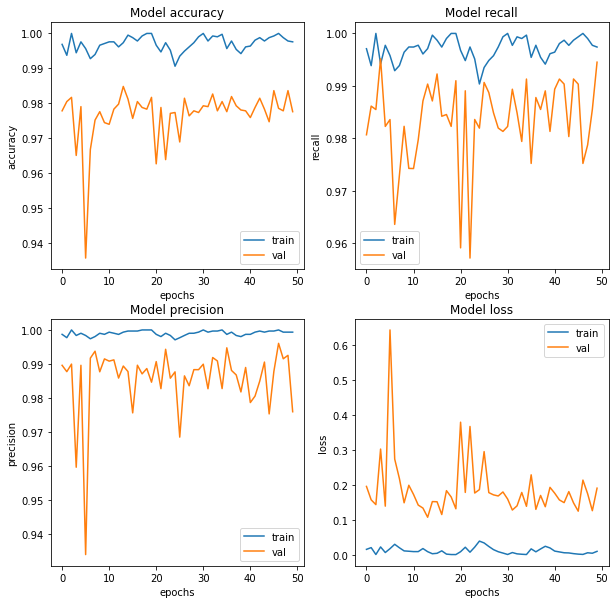

In [47]:
#훈련하며 쌓인 히스토리를 그래프로 만들어 확인
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'precision', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 109ms/step - loss: 9.0967 - accuracy: 0.7179 - precision: 0.6890 - recall: 1.0000


> - accuracy가 많이 떨어졌다. 잘 나올거라 생각했는데.. 많이 돌리는 것이 장땡이라는 말인가...!

## 2회차 개선 시도

__이번 모델에서 적용할 개선점 :__

1. 드롭아웃율을 조정(0.5-> 0.3)
2. 에포크를 늘리자(50->85)
3. class weight를 적용한다.

In [50]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        
        #마지막, 라벨을 분류해내는 Dense층만 추가
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [51]:
with tf.device('/GPU:0'):
    model_second= build_model_3()
    
    METRICS=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
#weight_for_0 == Normal 가중치
#weight_for_1 == PNEUMONIA 가중치     

weight_for_0 = (1/count_normal) * (train_tensor_count)/2.0
weight_for_1 = (1/count_pneumonia) * (train_tensor_count)/2.0

weights = {0:weight_for_0, 1:weight_for_1}

print('노말이 갖는 가중치 : {:.2f}'.format(weight_for_0))
print('폐렴이 갖는 가중치 : {:.2f}'.format(weight_for_1))

노말이 갖는 가중치 : 1.93
폐렴이 갖는 가중치 : 0.67


In [53]:
EPOCHS = 85

#모델 훈련
#이번에는 class weight 적용
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch= train_tensor_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data= validation_ds,
        validation_steps=train_tensor_count // BATCH_SIZE,
        class_weight= weights
    )

Epoch 1/85
130/130 [==============================] - 36s 276ms/step - loss: 0.0033 - accuracy: 0.9986 - precision: 0.9994 - recall: 0.9987 - val_loss: 0.2195 - val_accuracy: 0.9736 - val_precision: 0.9779 - val_recall: 0.9868
Epoch 2/85
130/130 [==============================] - 36s 279ms/step - loss: 0.0279 - accuracy: 0.9945 - precision: 0.9980 - recall: 0.9945 - val_loss: 0.1304 - val_accuracy: 0.9810 - val_precision: 0.9874 - val_recall: 0.9871
Epoch 3/85
130/130 [==============================] - 34s 264ms/step - loss: 0.0044 - accuracy: 0.9983 - precision: 0.9990 - recall: 0.9987 - val_loss: 0.2080 - val_accuracy: 0.9788 - val_precision: 0.9925 - val_recall: 0.9790
Epoch 4/85
130/130 [==============================] - 34s 260ms/step - loss: 0.0077 - accuracy: 0.9974 - precision: 0.9994 - recall: 0.9971 - val_loss: 0.2680 - val_accuracy: 0.9757 - val_precision: 0.9921 - val_recall: 0.9752
Epoch 5/85
130/130 [==============================] - 34s 259ms/step - loss: 0.0163 - accura

130/130 [==============================] - 32s 250ms/step - loss: 0.0273 - accuracy: 0.9942 - precision: 0.9984 - recall: 0.9939 - val_loss: 0.3073 - val_accuracy: 0.9649 - val_precision: 0.9859 - val_recall: 0.9668
Epoch 37/85
130/130 [==============================] - 32s 250ms/step - loss: 0.0039 - accuracy: 0.9981 - precision: 0.9994 - recall: 0.9981 - val_loss: 0.2027 - val_accuracy: 0.9810 - val_precision: 0.9887 - val_recall: 0.9858
Epoch 38/85
130/130 [==============================] - 32s 247ms/step - loss: 0.0092 - accuracy: 0.9976 - precision: 0.9987 - recall: 0.9981 - val_loss: 0.2183 - val_accuracy: 0.9805 - val_precision: 0.9852 - val_recall: 0.9887
Epoch 39/85
130/130 [==============================] - 32s 249ms/step - loss: 0.0293 - accuracy: 0.9947 - precision: 0.9984 - recall: 0.9945 - val_loss: 0.1811 - val_accuracy: 0.9781 - val_precision: 0.9845 - val_recall: 0.9861
Epoch 40/85
130/130 [==============================] - 32s 247ms/step - loss: 0.0336 - accuracy: 0.9

Epoch 72/85
130/130 [==============================] - 30s 232ms/step - loss: 0.0058 - accuracy: 0.9981 - precision: 0.9994 - recall: 0.9981 - val_loss: 0.1755 - val_accuracy: 0.9812 - val_precision: 0.9843 - val_recall: 0.9906
Epoch 73/85
130/130 [==============================] - 30s 234ms/step - loss: 0.0061 - accuracy: 0.9981 - precision: 0.9993 - recall: 0.9980 - val_loss: 0.2396 - val_accuracy: 0.9738 - val_precision: 0.9876 - val_recall: 0.9771
Epoch 74/85
130/130 [==============================] - 30s 234ms/step - loss: 0.0018 - accuracy: 0.9988 - precision: 0.9997 - recall: 0.9987 - val_loss: 0.2278 - val_accuracy: 0.9779 - val_precision: 0.9814 - val_recall: 0.9890
Epoch 75/85
130/130 [==============================] - 31s 235ms/step - loss: 0.0083 - accuracy: 0.9971 - precision: 0.9990 - recall: 0.9971 - val_loss: 0.2399 - val_accuracy: 0.9743 - val_precision: 0.9804 - val_recall: 0.9851
Epoch 76/85
130/130 [==============================] - 30s 230ms/step - loss: 0.0035 - a

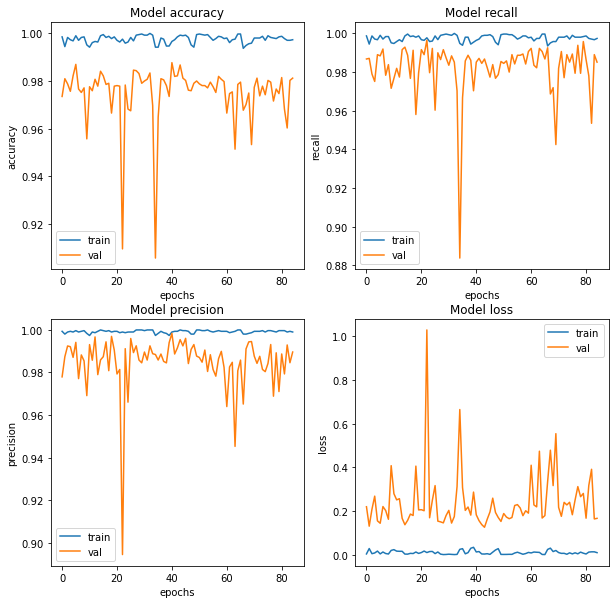

In [54]:
#훈련하며 쌓인 히스토리를 그래프로 만들어 확인
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'precision', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [55]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 110ms/step - loss: 7.0366 - accuracy: 0.7788 - precision: 0.7423 - recall: 0.9897


## 3회차 개선 시도              

__이번 모델에서 적용할 개선점 :__

1. 드롭아웃율을 조정(0.5-> 0.3)
2. 에포크를 늘리자(50->85)
3. class weight를 적용하지 않는다.

> - Accuracy가 다시 많이 올라왔는데, 단순히 25번의 횟수 차이가 원인이라고 보기 어렵다.     
> - 다른 변수는 2회차 모델과 동일하게 두고, 훈련 시 class weight만 제거해본다.

In [57]:
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        
        #마지막, 라벨을 분류해내는 Dense층만 추가
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [58]:
with tf.device('/GPU:0'):
    model_second= build_model_4()
    
    METRICS=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [59]:
EPOCHS = 85

#모델 훈련
#이번에는 class weight 적용
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch= train_tensor_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data= validation_ds,
        validation_steps=train_tensor_count // BATCH_SIZE,
        #class_weight= weights
    )

Epoch 1/85
130/130 [==============================] - 35s 266ms/step - loss: 0.0023 - accuracy: 0.9990 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.2477 - val_accuracy: 0.9757 - val_precision: 0.9759 - val_recall: 0.9919
Epoch 2/85
130/130 [==============================] - 34s 263ms/step - loss: 0.0092 - accuracy: 0.9983 - precision: 0.9987 - recall: 0.9990 - val_loss: 0.1915 - val_accuracy: 0.9774 - val_precision: 0.9848 - val_recall: 0.9848
Epoch 3/85
130/130 [==============================] - 34s 264ms/step - loss: 0.0101 - accuracy: 0.9976 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.1946 - val_accuracy: 0.9786 - val_precision: 0.9766 - val_recall: 0.9952
Epoch 4/85
130/130 [==============================] - 34s 261ms/step - loss: 0.0060 - accuracy: 0.9978 - precision: 0.9984 - recall: 0.9987 - val_loss: 0.2709 - val_accuracy: 0.9714 - val_precision: 0.9924 - val_recall: 0.9690
Epoch 5/85
130/130 [==============================] - 34s 259ms/step - loss: 0.0035 - accura

Epoch 37/85
130/130 [==============================] - 31s 236ms/step - loss: 0.0113 - accuracy: 0.9981 - precision: 0.9987 - recall: 0.9987 - val_loss: 0.4230 - val_accuracy: 0.9606 - val_precision: 0.9838 - val_recall: 0.9629
Epoch 38/85
130/130 [==============================] - 30s 233ms/step - loss: 0.0046 - accuracy: 0.9986 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.2641 - val_accuracy: 0.9784 - val_precision: 0.9849 - val_recall: 0.9861
Epoch 39/85
130/130 [==============================] - 31s 236ms/step - loss: 0.0117 - accuracy: 0.9988 - precision: 0.9990 - recall: 0.9994 - val_loss: 0.4500 - val_accuracy: 0.9630 - val_precision: 0.9577 - val_recall: 0.9942
Epoch 40/85
130/130 [==============================] - 30s 233ms/step - loss: 0.0065 - accuracy: 0.9986 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.2541 - val_accuracy: 0.9752 - val_precision: 0.9892 - val_recall: 0.9774
Epoch 41/85
130/130 [==============================] - 31s 236ms/step - loss: 0.0058 - a

Epoch 73/85
130/130 [==============================] - 32s 245ms/step - loss: 0.0104 - accuracy: 0.9981 - precision: 0.9990 - recall: 0.9984 - val_loss: 0.2405 - val_accuracy: 0.9755 - val_precision: 0.9826 - val_recall: 0.9845
Epoch 74/85
130/130 [==============================] - 32s 244ms/step - loss: 0.0064 - accuracy: 0.9983 - precision: 0.9987 - recall: 0.9990 - val_loss: 0.1989 - val_accuracy: 0.9781 - val_precision: 0.9830 - val_recall: 0.9877
Epoch 75/85
130/130 [==============================] - 32s 246ms/step - loss: 8.4075e-04 - accuracy: 0.9995 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.2289 - val_accuracy: 0.9779 - val_precision: 0.9827 - val_recall: 0.9877
Epoch 76/85
130/130 [==============================] - 32s 245ms/step - loss: 0.0029 - accuracy: 0.9993 - precision: 0.9994 - recall: 0.9997 - val_loss: 0.2827 - val_accuracy: 0.9750 - val_precision: 0.9937 - val_recall: 0.9726
Epoch 77/85
130/130 [==============================] - 32s 245ms/step - loss: 0.0050

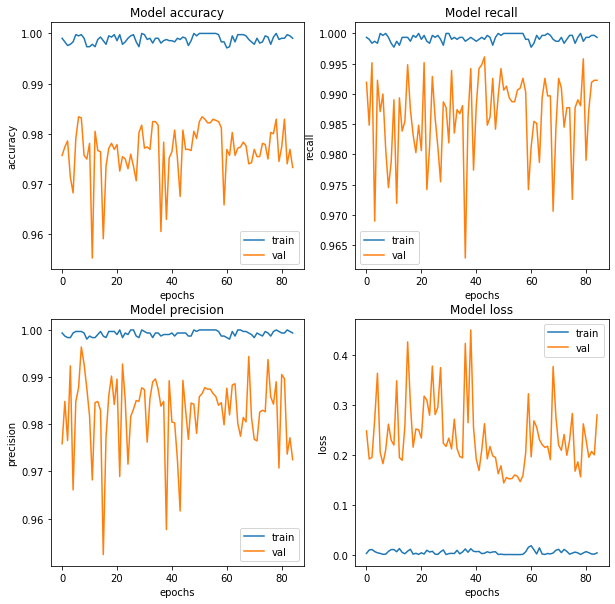

In [60]:
#훈련하며 쌓인 히스토리를 그래프로 만들어 확인
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'precision', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [61]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 106ms/step - loss: 9.0388 - accuracy: 0.7420 - precision: 0.7086 - recall: 0.9974


## 4회차 개선 시도              

__이번 모델에서 적용할 개선점 :__

1. 드롭아웃율을 원래대로 회복(0.2)
2. 에포크를 늘리자(150)
3. class weight를 적용한다.             

> - 짐작과는 다르게, class weight를 적용하지 않았더니 오히려 accuracy가 많이 내려갔다.     
> - 완전히 처음의 모델대로 하되, 에포크를 더 늘리고, class weight를 적용한다.(첫 시도때는 class weight가 없었다.)

In [62]:
def build_model_5():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        #마지막, 라벨을 분류해내는 Dense층만 추가
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [63]:
with tf.device('/GPU:0'):
    model_second= build_model_5()
    
    METRICS=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [64]:
EPOCHS = 150

#모델 훈련
#이번에는 class weight 적용
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch= train_tensor_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data= validation_ds,
        validation_steps=train_tensor_count // BATCH_SIZE,
        class_weight= weights
    )

Epoch 1/150
130/130 [==============================] - 34s 262ms/step - loss: 0.0010 - accuracy: 0.9993 - precision: 0.9997 - recall: 0.9994 - val_loss: 0.3196 - val_accuracy: 0.9745 - val_precision: 0.9889 - val_recall: 0.9768
Epoch 2/150
130/130 [==============================] - 34s 261ms/step - loss: 0.0026 - accuracy: 0.9990 - precision: 0.9997 - recall: 0.9990 - val_loss: 0.3150 - val_accuracy: 0.9712 - val_precision: 0.9934 - val_recall: 0.9677
Epoch 3/150
130/130 [==============================] - 34s 259ms/step - loss: 0.0055 - accuracy: 0.9981 - precision: 0.9994 - recall: 0.9981 - val_loss: 0.2349 - val_accuracy: 0.9776 - val_precision: 0.9886 - val_recall: 0.9813
Epoch 4/150
130/130 [==============================] - 34s 258ms/step - loss: 0.0084 - accuracy: 0.9978 - precision: 0.9990 - recall: 0.9981 - val_loss: 0.2094 - val_accuracy: 0.9779 - val_precision: 0.9871 - val_recall: 0.9832
Epoch 5/150
130/130 [==============================] - 34s 258ms/step - loss: 0.0101 - a

Epoch 37/150
130/130 [==============================] - 32s 246ms/step - loss: 0.0074 - accuracy: 0.9978 - precision: 0.9993 - recall: 0.9977 - val_loss: 0.2348 - val_accuracy: 0.9793 - val_precision: 0.9827 - val_recall: 0.9897
Epoch 38/150
130/130 [==============================] - 32s 249ms/step - loss: 0.0063 - accuracy: 0.9990 - precision: 0.9997 - recall: 0.9990 - val_loss: 0.2172 - val_accuracy: 0.9791 - val_precision: 0.9922 - val_recall: 0.9797
Epoch 39/150
130/130 [==============================] - 32s 248ms/step - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9990 - recall: 0.9984 - val_loss: 0.3462 - val_accuracy: 0.9673 - val_precision: 0.9987 - val_recall: 0.9574
Epoch 40/150
130/130 [==============================] - 32s 247ms/step - loss: 0.0029 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9990 - val_loss: 0.1676 - val_accuracy: 0.9805 - val_precision: 0.9877 - val_recall: 0.9861
Epoch 41/150
130/130 [==============================] - 32s 250ms/step - loss: 0.006

130/130 [==============================] - 30s 233ms/step - loss: 5.1780e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9798 - val_precision: 0.9830 - val_recall: 0.9900
Epoch 73/150
130/130 [==============================] - 31s 242ms/step - loss: 1.2170e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2541 - val_accuracy: 0.9769 - val_precision: 0.9805 - val_recall: 0.9887
Epoch 74/150
130/130 [==============================] - 32s 244ms/step - loss: 4.9018e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.9774 - val_precision: 0.9817 - val_recall: 0.9881
Epoch 75/150
130/130 [==============================] - 32s 246ms/step - loss: 1.9783e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2974 - val_accuracy: 0.9752 - val_precision: 0.9854 - val_recall: 0.9813
Epoch 76/150
130/130 [==============================] - 32s 245ms/step - loss: 6.

130/130 [==============================] - 32s 249ms/step - loss: 6.6644e-04 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9997 - val_loss: 0.2391 - val_accuracy: 0.9800 - val_precision: 0.9865 - val_recall: 0.9868
Epoch 108/150
130/130 [==============================] - 32s 248ms/step - loss: 0.0020 - accuracy: 0.9998 - precision: 0.9997 - recall: 1.0000 - val_loss: 0.2745 - val_accuracy: 0.9769 - val_precision: 0.9880 - val_recall: 0.9809
Epoch 109/150
130/130 [==============================] - 32s 250ms/step - loss: 0.0018 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9990 - val_loss: 0.2433 - val_accuracy: 0.9796 - val_precision: 0.9868 - val_recall: 0.9858
Epoch 110/150
130/130 [==============================] - 32s 249ms/step - loss: 8.4351e-04 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9997 - val_loss: 0.2150 - val_accuracy: 0.9846 - val_precision: 0.9897 - val_recall: 0.9897
Epoch 111/150
130/130 [==============================] - 32s 248ms/step - loss: 0.0018

130/130 [==============================] - 30s 234ms/step - loss: 2.7025e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1685 - val_accuracy: 0.9832 - val_precision: 0.9900 - val_recall: 0.9874
Epoch 143/150
130/130 [==============================] - 30s 234ms/step - loss: 3.9464e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1669 - val_accuracy: 0.9858 - val_precision: 0.9913 - val_recall: 0.9897
Epoch 144/150
130/130 [==============================] - 31s 235ms/step - loss: 9.1804e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1665 - val_accuracy: 0.9822 - val_precision: 0.9871 - val_recall: 0.9890
Epoch 145/150
130/130 [==============================] - 32s 248ms/step - loss: 1.3870e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1564 - val_accuracy: 0.9839 - val_precision: 0.9887 - val_recall: 0.9897
Epoch 146/150
130/130 [==============================] - 32s 244ms/step - loss

> - 기본 모델 + 파라미터를 바꾸는 단에서 돌릴 수 있는 데까지는 최선의 성과를 낸 것 같은데, 여전히 85%를 달성하지 못하는 것을 보면       
> - 근본적인 변화가 필요하다.

![150에포크결과](./PostingPic/150에포크.png)

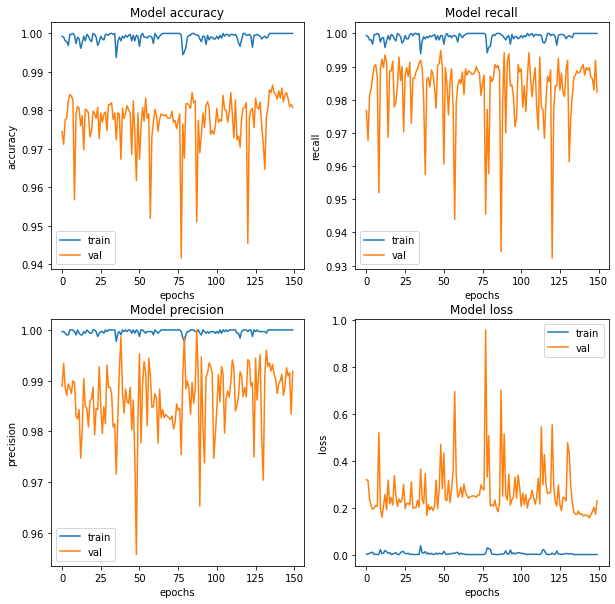

In [65]:
#훈련하며 쌓인 히스토리를 그래프로 만들어 확인
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'recall', 'precision', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [66]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 110ms/step - loss: 7.4413 - accuracy: 0.7821 - precision: 0.7442 - recall: 0.9923
